In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

# Generators

In [0]:
def image_generator(files, batch_size = 16, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256, 1) --> (20, 256, 256, 2)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 16 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [7]:
print (x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 2)


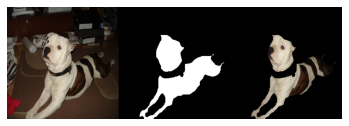

In [8]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)

msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256, 2) -> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return -(K.log(score))

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def block_residual(x, nKernels):
  identity = x
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity


# Model

In [0]:
from tensorflow.keras.layers import concatenate


def mnet(sz = (256, 256, 3)):
  x = Input(sz)
  input_feature = Conv2D(16, (1,1), activation='relu')(x)

  L_Leg_1 = MaxPooling2D((2,2)) (input_feature)
  L_Leg_2 = MaxPooling2D((2,2)) (L_Leg_1)
  L_Leg_3 = MaxPooling2D((2,2)) (L_Leg_2)

  # layer 1, size = (256, 256, 16)
  layer_1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_feature)
  layer_1_1 = BatchNormalization()(layer_1_1)
  layer_1_c = concatenate([layer_1_1, input_feature])
  layer_1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(layer_1_c)
  layer_1_2 = BatchNormalization()(layer_1_2)
  layer_1_p = MaxPooling2D((2, 2)) (layer_1_2)

  # layer 2
  layer_2_1 = concatenate([L_Leg_1, layer_1_p])
  layer_2_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (layer_2_1)
  layer_2_2 = BatchNormalization()(layer_2_2)
  layer_2_c = concatenate([layer_2_2, layer_1_p])

  layer_2_3 = Conv2D(48, (3, 3), activation='relu', padding='same')(layer_2_c)
  layer_2_3 = BatchNormalization()(layer_2_3)
  layer_2_p = MaxPooling2D((2, 2)) (layer_2_3)

  # layer 3
  layer_3_1 = concatenate([L_Leg_2, layer_2_p])
  layer_3_2 = Conv2D(48, (3, 3), activation='relu', padding='same') (layer_3_1)
  layer_3_2 = BatchNormalization()(layer_3_2)
  layer_3_c = concatenate([layer_3_2, layer_2_p])

  layer_3_3 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_3_c)
  layer_3_3 = BatchNormalization()(layer_3_3)
  layer_3_p = MaxPooling2D((2, 2)) (layer_3_3)

  # layer 4 (32, 32, 16) c (32, 32, 64)
  # (32, 32, 80)
  layer_4_1 = concatenate([L_Leg_3, layer_3_p])
  layer_4_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_4_1)
  layer_4_2 = BatchNormalization()(layer_4_2)
  # (32, 32, 64) c (32, 32, 64)
  # (32, 32, 128)
  layer_4_c = concatenate([layer_4_2, layer_3_p])
  layer_4_3 = Conv2D(128, (3, 3), activation='relu', padding='same') (layer_4_c)
  layer_4_3 = BatchNormalization()(layer_4_3)
  # (32, 32, 128)

  layer_4_4 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_4_3)
  layer_4_4 = BatchNormalization()(layer_4_4)
  # (32, 32, 64)

  # layer 5 
  layer_5_u = UpSampling2D((2, 2)) (layer_4_4)
  layer_5_1 = concatenate([layer_5_u, layer_3_3])
  # (64, 64, 64) c (64, 64, 64)
  layer_5_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_5_1)
  layer_5_2 = BatchNormalization()(layer_5_2)
  layer_5_c = concatenate([layer_5_2, layer_5_u])
  layer_5_3 = Conv2D(48, (3, 3), activation='relu', padding='same') (layer_5_c)
  layer_5_3 = BatchNormalization()(layer_5_3)

  # layer 6
  layer_6_u = UpSampling2D((2, 2)) (layer_5_3)
  layer_6_1 = concatenate([layer_6_u, layer_2_3])
  layer_6_2 = Conv2D(48, (3, 3), activation='relu', padding='same') (layer_6_1)
  layer_6_2 = BatchNormalization()(layer_6_2)
  layer_6_c = concatenate([layer_6_2, layer_6_u])
  layer_6_3 = Conv2D(32, (3, 3), activation='relu', padding='same') (layer_6_c)
  layer_6_3 = BatchNormalization()(layer_6_3)

  # layer 7
  layer_7_u = UpSampling2D((2, 2)) (layer_6_3)
  layer_7_1 = concatenate([layer_7_u, layer_1_2])
  layer_7_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (layer_7_1)
  layer_7_2 = BatchNormalization()(layer_7_2)
  layer_7_c = concatenate([layer_7_2, layer_7_u])
  layer_7_3 = Conv2D(16, (3, 3), activation='relu', padding='same') (layer_7_c)
  layer_7_3 = BatchNormalization()(layer_7_3)


  # R_Leg
  R_leg_1 = UpSampling2D((8, 8)) (layer_4_4)
  R_leg_2 = UpSampling2D((4, 4)) (layer_5_3)
  R_leg_3 = UpSampling2D((2, 2)) (layer_6_3)

  final_layer = concatenate([layer_7_3, R_leg_3, R_leg_2, R_leg_1])
  outputs = Conv2D(2, 1, activation='softmax') (final_layer)

  #model creation
  model = Model(inputs=[x], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])

  return model

In [0]:
model = mnet()

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [23]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

438 23


i= 1 loss= 0.9257159065029937 val_loss= 1.0802845747574517 mean_dsc= 0.6270324 val_mean_dsc= 0.6281848


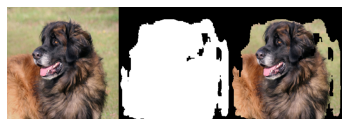

i= 2 loss= 0.5670153917106864 val_loss= 0.48617526500121405 mean_dsc= 0.7704572 val_mean_dsc= 0.80090994


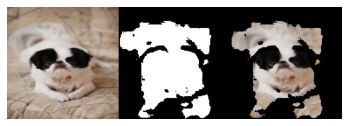

i= 3 loss= 0.460496732973617 val_loss= 0.4638523589009824 mean_dsc= 0.8157311 val_mean_dsc= 0.8172416


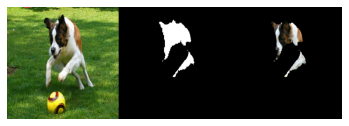

i= 4 loss= 0.39494831679754605 val_loss= 0.4393064690672833 mean_dsc= 0.8417601 val_mean_dsc= 0.81001234


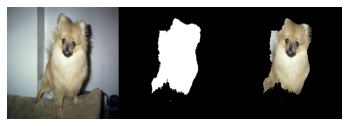

i= 5 loss= 0.3592196305933064 val_loss= 0.3891090050987575 mean_dsc= 0.8557447 val_mean_dsc= 0.84745026


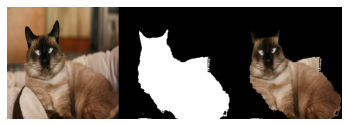

In [0]:
model.fit_generator(train_generator, 
                    epochs = 20, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [16]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-12 12:56:32--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.227.223.3, 13.227.223.14, 13.227.223.47, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.227.223.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.005s  

2020-05-12 12:56:32 (11.4 MB/s) - ‘test.jpg’ saved [63219/63219]



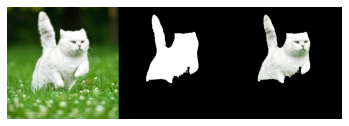

In [17]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

